# Идеи

1. Эмбеддинги самари и коментарии
2. Часовые пояса у пользователей
3. Порядковые номера тасков внутри проекта                     +++
4. Количество одновременно назначенных тасков у пользователя
5. Количество комментариев у таска                             +++

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
import pymorphy2
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor
from collections import Counter
import lightgbm

from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering

from transformers import AutoTokenizer, AutoModel
from umap.umap_ import UMAP
import torch

%matplotlib inline

In [ ]:
TOKENIZER = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
BERT = AutoModel.from_pretrained("cointegrated/rubert-tiny2")
MORPH = pymorphy2.MorphAnalyzer()


In [625]:
df_issues_train = pd.read_csv("data/train_issues.csv")
df_comment_train = pd.read_csv("data/train_comments.csv")

df_issues_test = pd.read_csv("data/test_issues.csv")
df_comment_test = pd.read_csv("data/test_comments.csv")

df_emp = pd.read_csv("data/employees.csv")

In [626]:
df_issues_test['overall_worklogs'] = -1
df_all = pd.concat([df_issues_train, df_issues_test])
df_all_com = pd.concat([df_comment_train, df_comment_test])

In [627]:
df_all

,id,created,key,summary,project_id,assignee_id,creator_id,overall_worklogs
0,819952,2019-10-01 05:57:18.000,SM-10678,"UI тесты по заказу ""Добро КейДжи""",5,93,93,1800
1,819949,2019-10-01 05:59:45.000,SM-10679,"UI тесты раздела ""Профиль""",5,93,93,7200
2,819947,2019-10-01 06:00:38.000,SM-10680,"UI тесты раздела ""Личный счет""",5,93,93,14400
3,819943,2019-10-01 06:02:49.000,SM-10682,"UI тесты раздела ""Новости""",5,93,93,900
4,819941,2019-10-01 06:03:26.000,SM-10683,"UI тесты раздела ""Зоны скидок и доплат""",5,93,93,900
...,...,...,...,...,...,...,...,...
1065,702545,2020-09-24 11:21:57.000,ADBKRK-1392,Order to fix: audit result & save root cause,48,1,1,-1
1066,702528,2020-09-28 14:09:35.000,ADBKRK-1402,Lỗi EPC không tải trang được,48,1,1,-1
1067,702499,2020-10-06 13:51:25.000,ADBKRK-1422,Line red cannot calling out from system: Audit...,48,1,1,-1
1068,702376,2020-11-05 15:40:21.000,ADBKRK-1493,ipphone problem: push & audit result,48,1,1,-1


### Предобработка

In [624]:
# ОБЪЕДИНЕНИЕ ВСЕХ ТЕКСТОВЫХ ДАННЫХ
def concat_all_text(X):    
    com_df = pd.merge(X, df_all_com, left_on="id", right_on="issue_id", how='left')
    com_df.text = com_df.text.fillna('')
    all_text = {}
    for val in X.id:
        all_text[val] = com_df[com_df.id == val].summary.iloc[0]
        all_text[val] += ' '.join([text for text in com_df[com_df.id == val].text.values])
    X['all_text'] = all_text.values()
    
# ДАТА И ВРЕМЯ
def encode_date(X):
    X.created = pd.to_datetime(X.created)
    X['day'] = X.created.dt.strftime('%d').astype(int)
    X['month'] = X.created.dt.strftime('%m-%y')
    X['hour'] = X.created.dt.strftime("%H").astype(int)
    X['day_of_week'] = X.created.dt.strftime("%w").astype(int)
    X.drop('created', axis=1, inplace=True)

# КОЛИЧЕСТВО И ДЛИНА КОММЕНТАРИЕВ
def process_coments(X):
    com_df = pd.DataFrame(pd.merge(X, df_all_com, left_on="id", right_on="issue_id", how='left'))
    com_df.text = com_df.text.astype('str')
    com_df.text = com_df.text.apply(len).astype('int')
    counts = com_df.groupby('id').comment_id.count()
    lens = com_df.groupby('id').text.sum()
    X['comments_count'] = pd.merge(X, counts, left_on='id', right_index=True).comment_id
    X['comments_len'] = pd.merge(X, lens, left_on='id', right_index=True).text
    
# ИНФОРМАЦИЯ ОБ ИСПОЛНИТЕЛЕ
def get_assignee_info(X):
    df = pd.merge(X, df_emp, left_on='assignee_id', right_on='id', how='left')
    df.fillna('unknown', inplace=True)
    col_list = ['position', 'hiring_type', 'payment_type', 'passport', 'is_nda_signed', 'is_labor_contract_signed', 'is_added_to_internal_chats', 'is_added_one_to_one']
    X[col_list] = df[col_list]

# СТАТИСТИКИ СОТРУДНИКОВ
def get_stats(X, field):
    train_df = X[X.overall_worklogs != -1]
    stats_df = train_df.groupby(field).agg({'overall_worklogs': [min, max, np.mean, np.median, np.std]})
    stats_df.columns = [f'{field.split("_")[0]}_{i}_time' for i in stats_df.columns.droplevel(0)]
    X[stats_df.columns] = pd.merge(X, stats_df, left_on=field, right_index=True, how='left')[stats_df.columns]
    
# TF-IDF UMAP
def preprocess(text: str) -> list:
    tokenized = nltk.word_tokenize(text.lower())
    normalized = [morph.parse(word)[0].normal_form for word in tokenized
                  if len(word) > 1 and word.isalpha()]
    return normalized

def tf_idf(freqs):
    return (freqs / (freqs.sum(axis=1) + 0.0001)[:, np.newaxis] ) * np.log(freqs.shape[0] / ((freqs >= 1).sum(axis=0) + 1))

def mess_to_vec(vocab: dict, message: list):
    vec = np.zeros(len(vocab) + 1)
    for token in message:
        if token in vocab:
            vec[vocab[token]] += 1
        else:
            vec[0] += 1
    return vec

def get_vocab(messages: list) -> dict:
    vocab = {}
    pos = 1
    cc = Counter()
    for message in messages:
        n_cc = Counter(message)
        for key in n_cc:
            n_cc[key] = 1
        cc += n_cc
    for key, val in cc.items():
        if val > 1:
            vocab[key] = pos
            pos += 1
    return vocab

def get_tf_idf_enc(vals, new_df, name):
    vocab = get_vocab(vals)
    all_freq = []
    for val in vals:
        all_freq.append(mess_to_vec(vocab, val))
    all_freq = np.array(all_freq)
    
    all_freq = tf_idf(all_freq)
    print(all_freq)
    reduct = UMAP(densmap=True,
                  dens_lambda=1.,
                  n_neighbors=10,
                  min_dist=0.0,
                  n_components=3,
                  random_state=42,
                  low_memory=False,
                  metric='cosine',
                  output_metric='euclidean'
                  )

    umap_res = reduct.fit_transform(all_freq).T
    for i in range(len(umap_res)):
        new_df[name + f'_umap_{i}'] = umap_res[i]

# BERT UMAP
def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

def get_bert_enc(X):   
    embeddings = []
    for sentence in X['all_text']:
        embeddings.append(embed_bert_cls(sentence, BERT, TOKENIZER))
    embeddings = np.array(embeddings)

    reduct = UMAP(densmap=True,
                  dens_lambda=1.,
                  n_neighbors=10,
                  min_dist=0.0,
                  n_components=3,
                  random_state=42,
                  low_memory=False,
                  metric='cosine',
                  output_metric='euclidean'
                  )

    umap_res = reduct.fit_transform(embeddings).T
    for i in range(len(umap_res)):
        X[f'bert_umap_{i}'] = umap_res[i]

# КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ
def make_categorical(df, col):
    df[col] = pd.Categorical(df[col])
    df[col] = df[col].astype('category').cat.codes
        
# ВСЕ ПРЕОБРАЗОВАНИЯ
def apply_technicals(X):
    concat_all_text(X)
    encode_date(X)
    process_coments(X)
    get_assignee_info(X)
    get_bert_enc(X)
    
    cat_cols = ['project_id', 'month', 'position', 'hiring_type', 'payment_type']
    for column in cat_cols:
        make_categorical(X, column)
    
    vals = [preprocess(word) for word in X.all_text]
    get_tf_idf_enc(vals, X, 'summary')
    
    for field in ['assignee_id', 'creator_id']:
        get_stats(df_all, field)
    
    X['key'] = X.key.apply(lambda x: x.split('-')[1]).astype('int')
    X['is_self_assigned'] = np.where(X.assignee_id == X.creator_id, 1, 0)
    X['len_summary'] = X['summary'].apply(len)
    X.drop(['id', 'summary', 'all_text'], axis=1, inplace=True)

In [ ]:
apply_technicals(df_all)

In [ ]:
df_all.head(10)

In [564]:
df_test = df_all[df_all.overall_worklogs == -1].copy()
df_test.drop('overall_worklogs', axis=1, inplace=True)
#df_test.drop(['bert_umap_0', 'bert_umap_1', 'bert_umap_2'], axis=1, inplace=True)

In [576]:
df_train = df_all[(df_all.overall_worklogs != -1) & (df_all.overall_worklogs < 2000000)].copy()
#df_train.drop('key', axis=1, inplace=True)
y = df_train.overall_worklogs
y = np.log(y+0.001)
X = df_train.drop('overall_worklogs', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
params = {'learning_rate': 0.1, 
          'depth': 12, 
          'l2_leaf_reg': 5, 
          'loss_function': 'RMSE', 
          'eval_metric': 'RMSE', 
          'task_type': 'CPU', 
          'iterations': 600,
          'od_type': 'Iter', 
          'boosting_type': 'Plain', 
          'bootstrap_type': 'Bernoulli', 
          'allow_const_label': True, 
          'logging_level': 'Silent',
          'random_state': 42
         }
gbt = CatBoostRegressor(**params)#, cat_features=[1,2,3,4,5,6,7,9,10,11,12,13,14,15,16])
gbt.fit(X_train, y_train)
print(r2_score(gbt.predict(X_train), y_train))
print(r2_score(gbt.predict(X_test), y_test))

In [ ]:
feat = pd.Series(gbt.feature_importances_, index=X_train.columns)
feat.sort_values(ascending=False)

In [577]:
lgbm = lightgbm.LGBMRegressor(num_leaves=30, n_estimators=3500, learning_rate=0.001)
lgbm = lgbm.fit(X_train, y_train,
                            eval_set=[(X_train, y_train), (X_test, y_test)],
                            eval_names=['train', 'val'], eval_metric=lgbm_r2, callbacks=[lightgbm.log_evaluation(500)])

[500]	train's l2: 1.27419	train's r2: 0.157471	val's l2: 1.31643	val's r2: 0.143039
[1000]	train's l2: 1.15795	train's r2: 0.234332	val's l2: 1.2184	val's r2: 0.206853
[1500]	train's l2: 1.08392	train's r2: 0.283279	val's l2: 1.16248	val's r2: 0.243259
[2000]	train's l2: 1.03084	train's r2: 0.318381	val's l2: 1.13116	val's r2: 0.263642
[2500]	train's l2: 0.988061	train's r2: 0.346666	val's l2: 1.11187	val's r2: 0.2762
[3000]	train's l2: 0.952313	train's r2: 0.370304	val's l2: 1.09974	val's r2: 0.284096
[3500]	train's l2: 0.921459	train's r2: 0.390705	val's l2: 1.09178	val's r2: 0.289277


In [607]:
lgbm_feat = pd.Series(lgbm.feature_importances_, index=X_train.columns)
lgbm_feat.sort_values(ascending=False)

key                           11416
comments_len                   8733
bert_umap_2                    8304
month                          7260
bert_umap_0                    6886
bert_umap_1                    6399
len_summary                    5847
assignee_median_time           4882
summary_umap_2                 4430
summary_umap_0                 4304
summary_umap_1                 4252
comments_count                 3129
day                            2883
assignee_mean_time             2801
hour                           2431
creator_median_time            2219
creator_max_time               2172
assignee_max_time              1802
creator_id                     1782
is_self_assigned               1420
assignee_id                    1411
project_id                     1232
creator_mean_time              1023
assignee_min_time               943
creator_std_time                880
creator_min_time                697
assignee_std_time               622
day_of_week                 

In [601]:
res_val_df = pd.DataFrame(np.exp(y_test))
res_val_df['pred'] = np.exp(lgbm.predict(X_test))

In [605]:
df_all.loc[5841]

key                           7.139000e+03
project_id                    1.000000e+00
assignee_id                   1.490000e+02
creator_id                    1.000000e+00
overall_worklogs              3.414000e+05
day                           1.600000e+01
month                         3.000000e+01
hour                          1.000000e+01
day_of_week                   0.000000e+00
comments_count                0.000000e+00
comments_len                  3.000000e+00
position                      4.000000e+00
hiring_type                   2.000000e+00
payment_type                  2.000000e+00
passport                      0.000000e+00
is_nda_signed                 0.000000e+00
is_labor_contract_signed      0.000000e+00
is_added_to_internal_chats    0.000000e+00
is_added_one_to_one           0.000000e+00
bert_umap_0                  -3.020073e-01
bert_umap_1                   6.870250e+00
bert_umap_2                   7.244742e+00
summary_umap_0                9.810066e+00
summary_uma

In [610]:
res_val_df.describe()

,overall_worklogs,pred
count,2397.000000,2397.000000
mean,14604.406507,8393.415941
std,33718.880108,8474.081889
min,60.001000,853.386768
25%,3000.001000,5060.987411
50%,7200.001000,6512.935430
75%,14400.001000,8538.602699
max,594600.001000,120601.168760


In [581]:
r2_score(np.exp(y_test), np.exp(lgbm.predict(X_test)))

0.13065615293514132

<AxesSubplot:xlabel='overall_worklogs', ylabel='Count'>

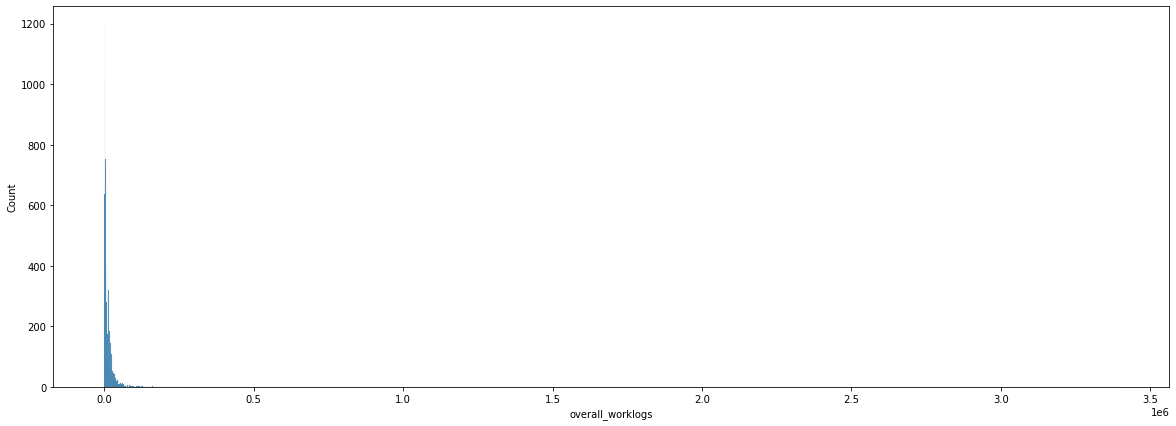

In [523]:
plt.figure(figsize=(20,7))
sns.histplot(df_train.overall_worklogs)

<AxesSubplot:ylabel='Count'>

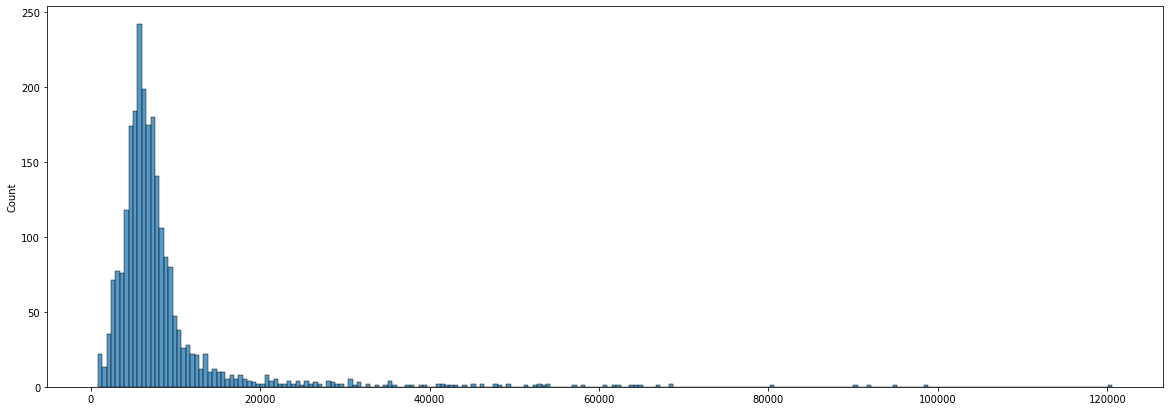

In [580]:
plt.figure(figsize=(20,7))
#sns.histplot(lgbm.predict(X_test))
sns.histplot(np.exp(lgbm.predict(X_test)))

<AxesSubplot:xlabel='overall_worklogs', ylabel='Count'>

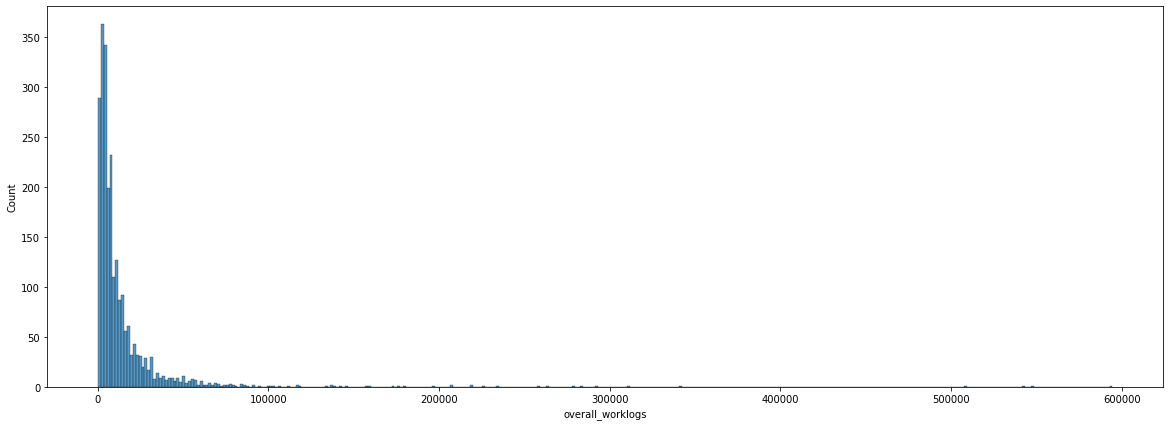

In [578]:
plt.figure(figsize=(20,7))
sns.histplot(np.exp(y_test))

In [608]:
pred = lgbm.predict(df_test)
pred = np.where(pred<0, 600, pred)
pred = np.exp(pred)

In [609]:
ind_df = pd.read_csv('data/solution_01.csv')
solution = pd.DataFrame({'overall_worklogs': pred}, index=ind_df.id)
solution.to_csv('data/solution_07.csv')

In [ ]:
def lgbm_r2(y_true, y_pred):
    return 'r2', r2_score(y_true, y_pred), True

In [ ]:
val_pred = pd.Series(lgbm.predict(X_test))
val_pred = np.where(val_pred<0, 600, val_pred)
val_pred

In [ ]:
val_pred.min()

In [ ]:
r2_score(y_test, val_pred)

In [ ]:
sns.clustermap(np.abs(df_train.corr('spearman')), figsize=(25, 25), annot=True)
plt.show()

In [617]:
com_df = pd.merge(df_issues_train, df_comment_train, left_on="id", right_on="issue_id", how='left')
com_df.text = com_df.text.fillna('')
all_comments = {}
for val in com_df[:50].id:
    all_text[val] = com_df[com_df.id == val].summary.iloc[0]
    all_text[val] += ' '.join([text for text in com_df[com_df.id == val].text.values])
    

In [ ]:
com_df[com_df.text.str.contains('later|tomorrow|завтра|потом')].overall_worklogs.median()

In [ ]:
com_df.info()

In [618]:
all_text

{819952: 'UI тесты по заказу "Добро КейДжи"',
 819949: 'UI тесты раздела "Профиль"Приверила и приняла MR\n\n\xa0',
 819947: 'UI тесты раздела "Личный счет"',
 819943: 'UI тесты раздела "Новости"',
 819941: 'UI тесты раздела "Зоны скидок и доплат"Приняла mR',
 819938: 'UI тесты раздела "Чат со службой поддержки"Приняла MR',
 819935: 'UI тесты раздела "Помощь"',
 819933: 'Сделать разделение по мобильным операторамДобавил возможность отправлять требуемому оператору согласно префиксу номера. Коммит:\xa0[https://gitlab.com/TaxiNamba/taxi-sms-go/tree/NT-10686__Mobile_Ops] Код в репо есть. Ссылка на коммит не ссылка на коммит. Задача выполнена',
 819931: 'UI тесты раздела "Тур по приложению"',
 819927: 'UI тесты разделов "О системе" и "Рассказать друзьям"',
 819924: 'Не отрабатывает cdr_calc_durations[~mursidinovz] По поводу сентри почитай доку как настроить логирование ошибок для сентри там вроде как то по особенному настраивается  Ошибка оказалась не в коде, а в неправильных путях к задачам